In [49]:
from typing import List, Dict
import pandas as pd
from pathlib import Path
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(15,8)})

In [50]:
data_path = Path("../data/nemea_results__20210222/sizes")

def load_table(path: Path) -> DataFrame:
    all_entries: List[List[str]] = []
    column_names: List[str] = []
    types: List[str] = []
    with path.open() as file:
        table_starts: bool = False
        for line in file:
            if len(column_names) != 0 and table_starts and not '|' in line:
                break
            if not '|' in line:
                continue
            if len(column_names) == 0:
                column_names = [entry.replace(" ", "")
                                for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if len(types) == 0:
                types =  [entry.replace(" ", "")
                          for entry in line.split("|") if entry != "" and entry != "\n"]
                continue
            if "<ValueS>" in line:
                table_starts = True
                continue
            if not table_starts:
                continue
            new_entry: List[str] = [entry.replace(" ", "")
                                    for entry in line.split("|") if entry != "" and entry != "\n"]
            all_entries.append(new_entry)
    as_type: Dict[str, str] = {column_names[i]:types[i] for i in range(0, len(column_names))}
    return DataFrame(data=all_entries, columns=column_names).astype(as_type)

default_filename = "sizes_dictionary.txt"
default = load_table(data_path / default_filename)

grouped_by_column = default.groupby(["table_name", "column_name", "column_data_type"], as_index=False)["size_in_bytes"].sum()
columns_per_data_type = grouped_by_column.groupby(["column_data_type"], as_index=False)["column_name"].count()
size_per_data_type = grouped_by_column.groupby(["column_data_type"], as_index=False)["size_in_bytes"].sum()
print("number of columns per datatype")
print(columns_per_data_type)

#simdcai = load_table(data_path / "sizes_SIMDCAI.txt")
#dictionary = load_table(data_path / "sizes_Dictionary.txt")
#turbopfor = load_table(data_path / "sizes_turboPFOR.txt")
#bitpacking = load_table(data_path / "sizes_bitpacking_turbopfor.txt")

number of columns per datatype
  column_data_type  column_name
0            float            9
1              int           19
2           string           33


In [51]:
def compute_sizes(df):
    total_size = df["size_in_bytes"].sum()

    int_col_size = df[df["column_data_type"].str.match("int")]["size_in_bytes"].sum()
    float_col_size = df[df["column_data_type"].str.match("float")]["size_in_bytes"].sum()
    string_col_size = df[df["column_data_type"].str.match("string")]["size_in_bytes"].sum()

    return (total_size, int_col_size, float_col_size, string_col_size)

(default_size, default_int_col_size, default_float_col_size, default_string_col_size) = compute_sizes(default)
print("default dict size ", default_size)
print("default dict int col size ", default_int_col_size)
print("default int col portion of size ", default_int_col_size / default_size)

names = []
total_sizes = []
int_col_sizes = []
float_col_sizes = []
string_col_sizes = []
directory = os.fsencode(data_path)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):
        df = load_table(data_path / filename)
        names.append(filename)
        (total_size, int_col_size, float_col_size, string_col_size) = compute_sizes(df)
        total_sizes.append(total_size)
        int_col_sizes.append(int_col_size)
        float_col_sizes.append(float_col_size)
        string_col_sizes.append(string_col_size)

df = pd.DataFrame(data={'filename': names, 'total_size': total_sizes, 'int_col_sizes': int_col_sizes, 'float_col_sizes': float_col_sizes, 'string_col_sizes': string_col_sizes})
df["codec"] = [f.replace("sizes_", "").replace(".txt", "") for f in df["filename"]]
df = df.sort_values("codec")
df

default dict size  9999839546
default dict int col size  1372782099
default int col portion of size  0.13728041261913265


,filename,total_size,int_col_sizes,float_col_sizes,string_col_sizes,codec
0,sizes_bitpacking_compactvector.txt,9868210083,1445245248,664533612,7758431223,bitpacking_compactvector
1,sizes_bitpacking_turbopfor.txt,9713373626,1355351562,634173721,7723848343,bitpacking_turbopfor
3,sizes_bitpacking_turbopfor_seq.txt,9713373626,1355351562,634173721,7723848343,bitpacking_turbopfor_seq
4,sizes_dictionary.txt,9999839546,1372782099,676386560,7950670887,dictionary
2,sizes_fsba.txt,9999839546,1372782099,676386560,7950670887,fsba
5,sizes_simdbp.txt,9552397107,1307080816,602595564,7642720727,simdbp


<AxesSubplot:xlabel='Library/Codec', ylabel='total_size Footprint TPCH SF10 in GB'>

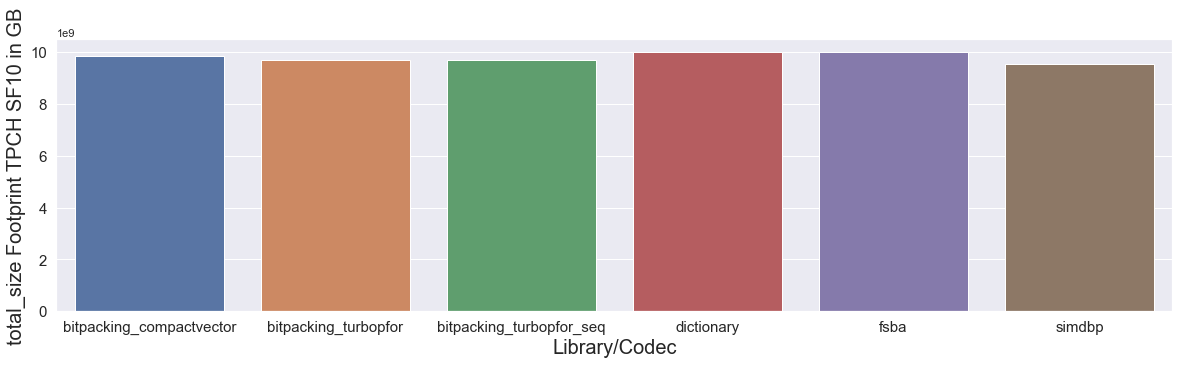

In [55]:
# https://stackoverflow.com/questions/28904397/how-to-set-the-value-of-the-axis-multiplier-in-matplotlib
class MagnitudeFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def plot(d, col, filename, plot=None):
    plt.tight_layout()
    if plot is None:
        plot = sns.barplot(data=d, x="codec", y=col)
    #plot.set(ylim=(1.5 * 10**9, 2.05 * 10**9))
    plot.set_xlabel("Library/Codec",fontsize=20)
    plot.set_ylabel(col + " Footprint TPCH SF10 in GB",fontsize=20) 
    plot.tick_params(labelsize=15)
    plot.yaxis.set_major_formatter(MagnitudeFormatter(9))
    #plot.ticklabel_format(axis="y", style="sci", scilimits=())
    sns.set(rc={'figure.figsize':(20,10)})
    plt.savefig(f"visualizations/{filename}.svg", format="svg")
    return plot

plot(df, "total_size", "tpch_compression_total_sizes")

<AxesSubplot:xlabel='Library/Codec', ylabel='int_col_sizes Footprint TPCH SF10 in GB'>

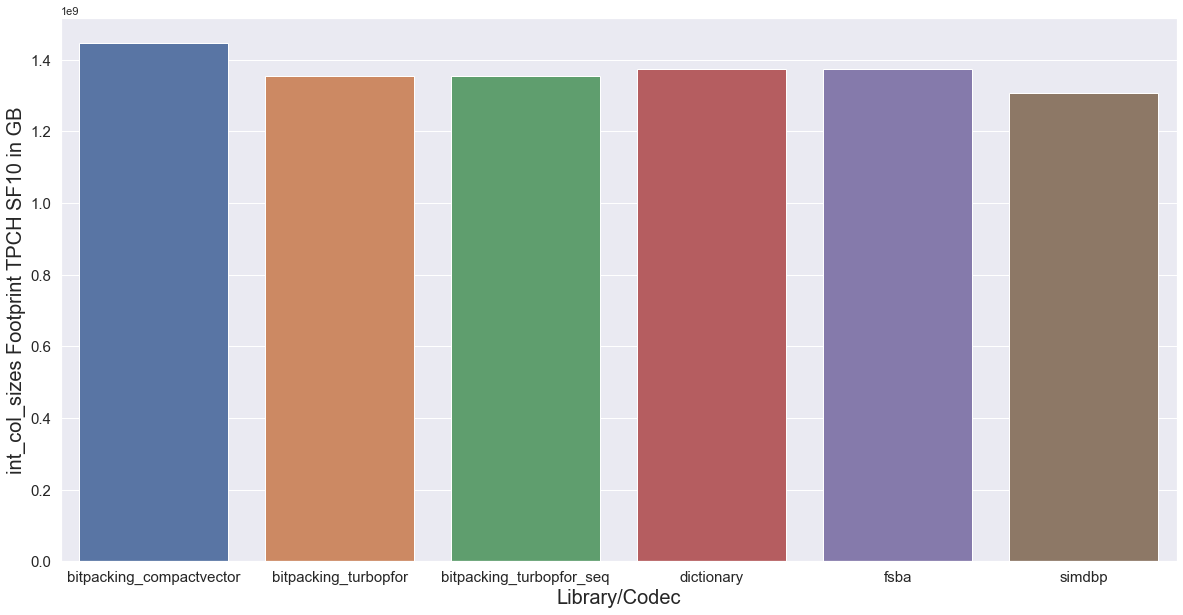

In [56]:
plot(df, "int_col_sizes", "tpch_compression_int_col_sizes")

<AxesSubplot:xlabel='Library/Codec', ylabel='float_col_sizes Footprint TPCH SF10 in GB'>

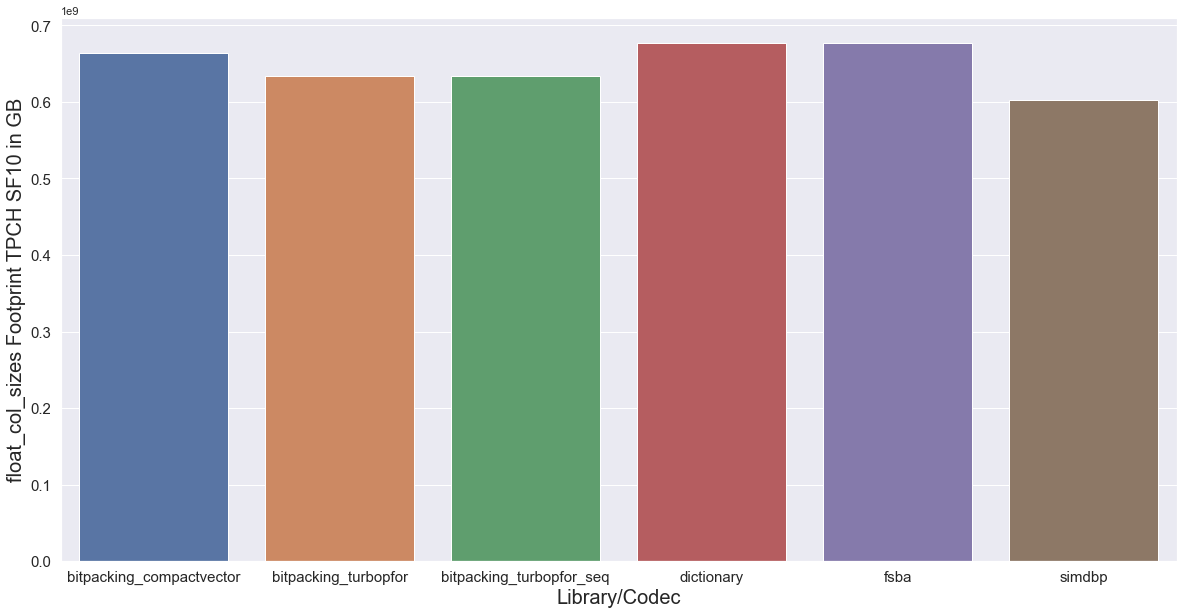

In [57]:
plot(df, "float_col_sizes", "tpch_compression_float_col_sizes")

<AxesSubplot:xlabel='Library/Codec', ylabel='string_col_sizes Footprint TPCH SF10 in GB'>

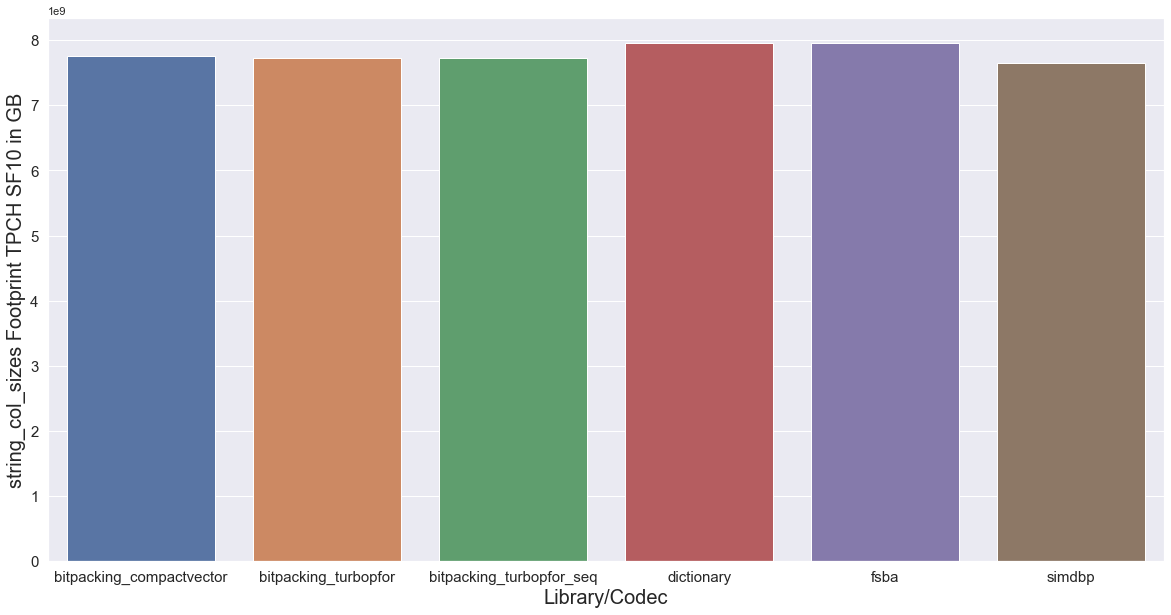

In [58]:
plot(df, "string_col_sizes", "tpch_compression_string_col_sizes")